# Sharp vs Flat Minima – Companion Notebook for Chapter 4

This notebook accompanies **Section 4.3 (Universal Geometric Principles of Deep Learning)**, and in particular the discussion of:
- **Flat vs sharp minima** in the loss landscape.
- The role of **SGD noise, batch size, and learning rate** in shaping the geometry of learned solutions.

It provides small-scale PyTorch experiments that:
- Train neural networks under different optimization hyperparameters.
- Visualize loss trajectories and, where feasible, approximate curvature/landscape diagnostics.
- Illustrate the qualitative distinction between “sharp” and “flat” solutions discussed in the chapter.


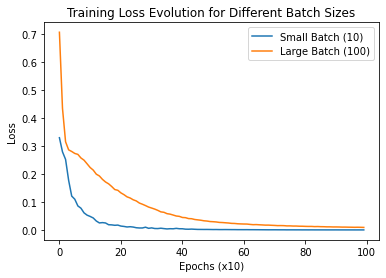

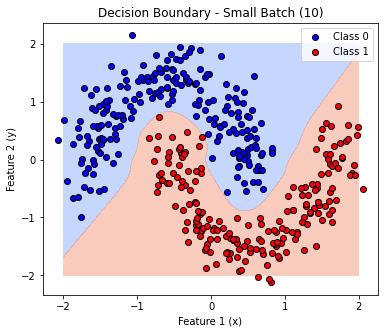

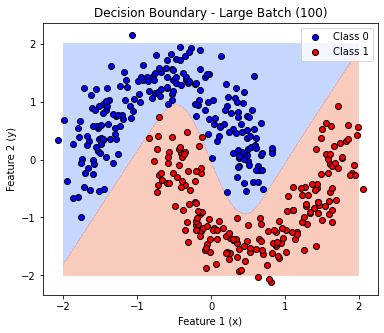

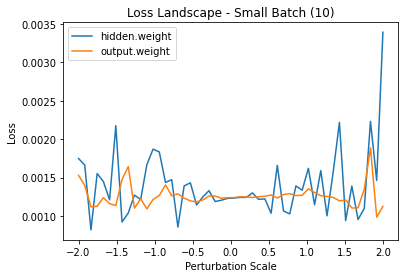

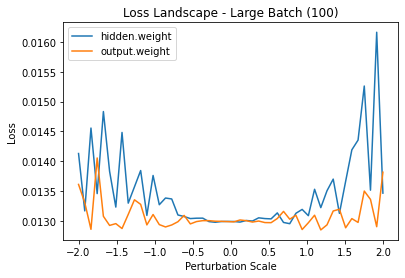

In [33]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# ==== GENERATE DATA ====
X, y = make_moons(n_samples=500, noise=0.15, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# ==== DEFINE NEURAL NETWORK ====
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.hidden = nn.Linear(2, 10)  # 2 inputs → 10 neurons
        self.output = nn.Linear(10, 1)  # 10 neurons → 1 output

    def forward(self, x):
        x = torch.tanh(self.hidden(x))  # Activation function
        x = torch.sigmoid(self.output(x))  # Sigmoid for binary classification
        return x

# ==== TRAIN FUNCTION ====
def train_nn(batch_size, learning_rate=0.01, epochs=500):
    model = SimpleNN()
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    loss_history = []

    for epoch in range(epochs):
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            y_pred = model(batch_X)
            loss = criterion(y_pred, batch_y)
            loss.backward()
            optimizer.step()
        
        if epoch % 5 == 0:
            with torch.no_grad():
                y_pred_test = model(X_test_tensor)
                loss_test = criterion(y_pred_test, y_test_tensor).item()
                loss_history.append(loss_test)

    return model, loss_history

# ==== TRAIN MODELS ====
small_batch_model, small_batch_loss = train_nn(batch_size=10)   # Small batch (More SGD noise)
large_batch_model, large_batch_loss = train_nn(batch_size=100)  # Large batch (Less SGD noise)

# ==== PLOT TRAINING LOSS ====
plt.figure(figsize=(6, 4))
plt.plot(small_batch_loss, label="Small Batch (10)")
plt.plot(large_batch_loss, label="Large Batch (100)")
plt.xlabel("Epochs (x10)")
plt.ylabel("Loss")
plt.title("Training Loss Evolution for Different Batch Sizes")
plt.legend()
plt.show()

# ==== DECISION BOUNDARY VISUALIZATION ====
def plot_decision_boundary(model, title):
    plt.figure(figsize=(6, 5))
    xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
    grid = np.c_[xx.ravel(), yy.ravel()]
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    with torch.no_grad():
        preds = model(grid_tensor).numpy().reshape(xx.shape)

    plt.contourf(xx, yy, preds, levels=[0, 0.5, 1], cmap="coolwarm", alpha=0.5)
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], color='blue', edgecolors='k', label="Class 0")
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], color='red', edgecolors='k', label="Class 1")
    plt.xlabel("Feature 1 (x)")
    plt.ylabel("Feature 2 (y)")
    plt.legend()
    plt.title(title)
    plt.show()

# ==== SHOW DECISION BOUNDARIES ====
plot_decision_boundary(small_batch_model, "Decision Boundary - Small Batch (10)")
plot_decision_boundary(large_batch_model, "Decision Boundary - Large Batch (100)")

# ==== LOSS LANDSCAPE VISUALIZATION ====
def compute_loss_landscape(model, param_name, alpha_range=(-2, 2), steps=50):
    """Compute loss landscape along a parameter direction."""
    param = dict(model.named_parameters())[param_name]
    param_backup = param.clone().detach()
    alphas = np.linspace(alpha_range[0], alpha_range[1], steps)
    losses = []

    criterion = nn.BCELoss()

    with torch.no_grad():
        for alpha in alphas:
            perturbed_param = param_backup + alpha * torch.randn_like(param_backup) * 0.05  # Small perturbation
            param.data = perturbed_param  # SAFE modification

            y_pred = model(X_train_tensor)
            loss = criterion(y_pred, y_train_tensor).item()
            losses.append(loss)

    param.data = param_backup  # Restore original parameter
    return alphas, losses

# ==== COMPUTE LOSS LANDSCAPE FOR MULTIPLE PARAMETERS ====
def plot_loss_landscape(model, param_names, title):
    plt.figure(figsize=(6, 4))
    
    for param_name in param_names:
        alphas, losses = compute_loss_landscape(model, param_name)
        plt.plot(alphas, losses, label=f"{param_name}")

    plt.xlabel("Perturbation Scale")
    plt.ylabel("Loss")
    plt.title(title)
    plt.legend()
    plt.show()

# ==== SELECT MULTIPLE PARAMETERS ====
param_names = ["hidden.weight", "output.weight"]

# ==== PLOT LOSS LANDSCAPE FOR BOTH MODELS ====
plot_loss_landscape(small_batch_model, param_names, "Loss Landscape - Small Batch (10)")
plot_loss_landscape(large_batch_model, param_names, "Loss Landscape - Large Batch (100)")
